In [1]:
import os
import sys
## change the path of your owne latest version VITAE.
sys.path.append(r"/home/jinhongd/jingshu/VITAE-mm-pi-mm_added_pi/")
path_data = "/home/jinhongd/jingshu/VITAE-mm-pi-mm_added_pi/data"
path_weight = 'weight/model_inference.checkpoint'
path_result = 'result/'
os.makedirs(path_result, exist_ok=True)

from numpy.matrixlib.defmatrix import matrix
import pandas as pd
import scanpy as sc
import anndata
import numpy as np

import VITAE
from VITAE.utils import load_data, reset_random_seeds
import tensorflow as tf
import random

import matplotlib.pyplot as plt
import seaborn as sns

2023-09-13 21:02:19.636523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :home/jinhond/hdf5-1.10.5/lib
2023-09-13 21:02:19.636555: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-13 21:02:22.191136: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :home/jinhond/hdf5-1.10.5/lib
2023-09-13 21:02:22.191280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or director

# Figure S6a1-2

2023-09-13 21:46:44.267667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :home/jinhond/hdf5-1.10.5/lib
2023-09-13 21:46:44.267697: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-13 21:46:44.267718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hydra8.stat.cmu.edu): /proc/driver/nvidia/version does not exist


Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.
Calculate UMAP ...


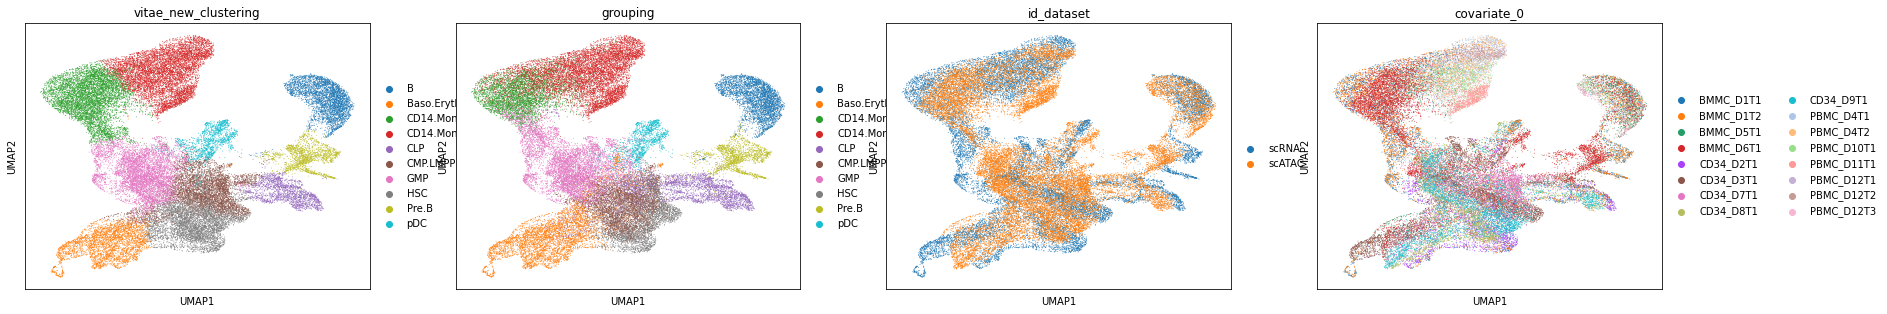

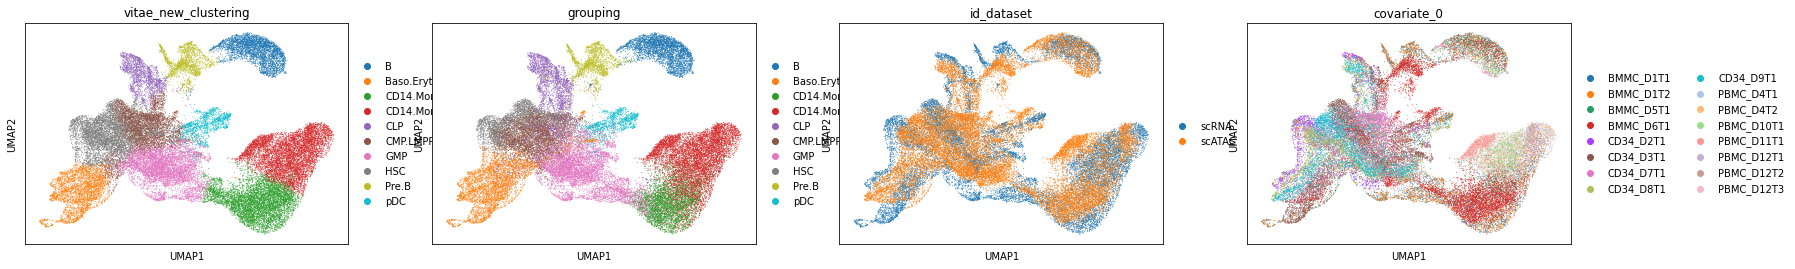

In [9]:
# Load data and preprocess
adata_atac = load_data(path_data, 'human_hematopoiesis_scATAC')
adata_rna = load_data(path_data, 'human_hematopoiesis_scRNA')
adata_motif = load_data(path_data, 'human_hematopoiesis_motif')

celltype_exclude = ['CD4.M', 'CD4.N', 'CD8.CM', 'CD8.EM', 'CD8.N', 'NK', 'Plasma', 'cDC', 'CD16.Mono']
adata_motif = adata_motif[~np.isin(adata_atac.obs['grouping'], celltype_exclude),:]
adata_atac = adata_atac[~np.isin(adata_atac.obs['grouping'], celltype_exclude),:]
adata_rna = adata_rna[~np.isin(adata_rna.obs['grouping'], celltype_exclude),:]


# preprocess
hvg = []
for adata in [adata_atac, adata_rna]:  
    dd = adata.copy()    
    sc.pp.normalize_total(dd, target_sum=1e4)
    sc.pp.log1p(dd)
    hvg.append(
        sc.pp.highly_variable_genes(dd, inplace=False))
id_bool_genes = (hvg[0]['highly_variable']|hvg[1]['highly_variable']).values
adata_atac = adata_atac[:,id_bool_genes]
adata_rna = adata_rna[:,id_bool_genes]

import anndata
adata = anndata.concat([adata_rna,adata_atac], index_unique=None)

n_atac = adata_motif.X.shape[0]
n_rna = adata.X.shape[0] - adata_motif.X.shape[0]
adata.obs['batch'] = pd.DataFrame(
    np.r_[np.zeros(n_rna), np.ones(n_atac)],
    index=adata.obs_names).astype('category')
adata.obs['id_dataset'] = adata.obs['batch'].cat.rename_categories({'0': 'scRNA', '1': 'scATAC'})
adata.obs['location'] = adata.obs['covariate_0'].str.split('_', expand=True).iloc[:,0]
adata.obs['location'] = adata.obs['location'].astype('category')
adata.obs['tissue'] = adata.obs['covariate_0'].str.split('_', expand=True).iloc[:,1].str.split('T', expand=True).iloc[:,1]
adata.obs['tissue'] = adata.obs['tissue'].astype('category')
adata.obs['day'] = adata.obs['covariate_0'].str.split('_D', expand=True).iloc[:,1].str.split('T', expand=True).iloc[:,0]
adata.obs['day'] = adata.obs['day'].astype('int').astype('category')

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

# merge small celltypes
dict_merge = {
    'Baso.Eryth':['Early.Baso','Early.Eryth', 'Late.Eryth'],
    'GMP':['GMP', 'GMP.Neut']
             }
merged_groupings = adata.obs['grouping'].astype(str).values
for key in dict_merge.keys():
    merged_groupings[
        np.isin(merged_groupings, dict_merge[key])] = key
adata.obs["grouping"] = merged_groupings
adata.obs["grouping"] = adata.obs["grouping"].astype("category")

cond_group = np.unique(merged_groupings).astype(str)
for group in cond_group:
    col_name = 'cond_'+group    
    adata.obs[col_name] = np.where(merged_groupings==group, adata.obs['id_dataset'].values, np.nan)
cond = np.char.add('cond_', cond_group)
adata.obs[cond] = adata.obs[cond].astype("category")


# run the model
reset_random_seeds(400)
tf.keras.backend.clear_session() 
model = VITAE.VITAE(adata = adata, covariates=['id_dataset'], conditions=cond,
                    model_type = 'Gaussian', 
                    npc=128, hidden_layers = [32,16], latent_space_dim=8)

model.load_model(path_to_file=path_weight, load_labels=True, load_adata=True)

model.labels_map.iloc[5,0] = 'HSC'
model.labels_map.iloc[7,0] = 'CMP.LMPP'
model._adata.obs['vitae_new_clustering'] = model.adata.obs['vitae_new_clustering'].replace({'HSC':'CMP.LMPP','CMP.LMPP':'HSC'})
model._adata.obs['day'] = adata.obs['day'].astype('int').astype('category')

model.visualize_latent(
    color = ['vitae_new_clustering','grouping','id_dataset','covariate_0'], method = "UMAP")
model._adata_z.obsm['X_umap'] = model._adata_z.obsm['X_umap'][:,[1,0]]
model.visualize_latent(
    color = ['vitae_new_clustering','grouping','id_dataset','covariate_0'], method = "UMAP")

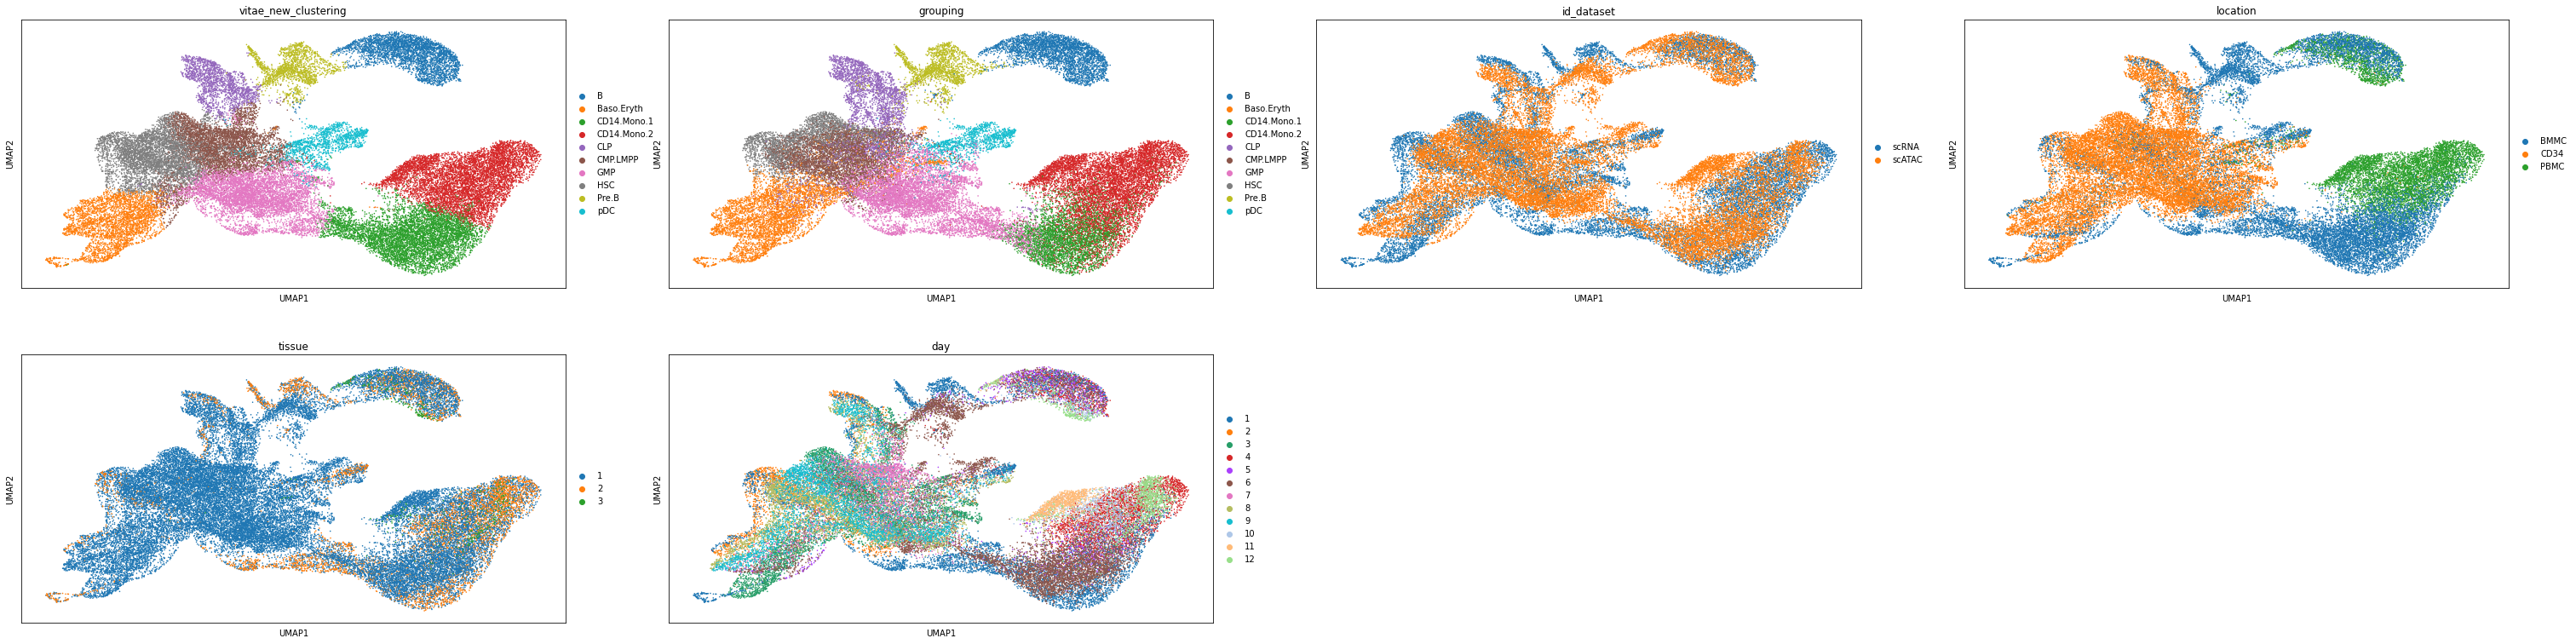

In [10]:
plt.rcParams["figure.figsize"] = [12,6]
fig = model.visualize_latent(
    color = ['vitae_new_clustering','grouping','id_dataset','location','tissue','day'], 
    method = "UMAP", size=10, return_fig=True)

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


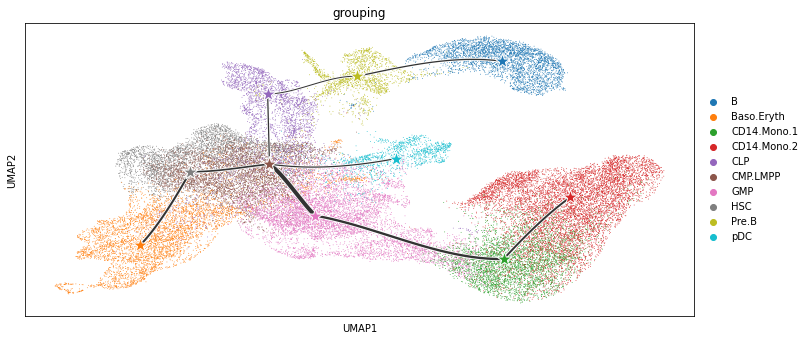

In [11]:
model.infer_backbone(cutoff=0, method = "raw_map", visualize=False)
ax = model.plot_backbone(color='grouping')

# Figure 6a-1

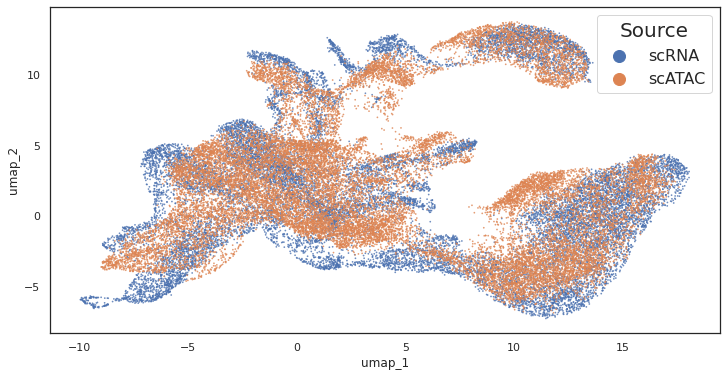

In [12]:
plt.rcParams["figure.figsize"] = [12,6]
sns.set(font_scale=2)
sns.set_theme(style='white')

df = pd.DataFrame(
    {'umap_1':model._adata.obsm['X_umap'][:,0],
    'umap_2':model._adata.obsm['X_umap'][:,1],
     'Celltype':model._adata.obs['grouping'].values,
     'Source':model._adata.obs['id_dataset'].values
    }
)
sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='Source', 
                s=3, alpha=0.8, edgecolor="none"
               )
plt.legend(title='Source', fontsize=16, title_fontsize=20, markerscale=2)
plt.savefig('Figure6a1.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Figure 6a-2

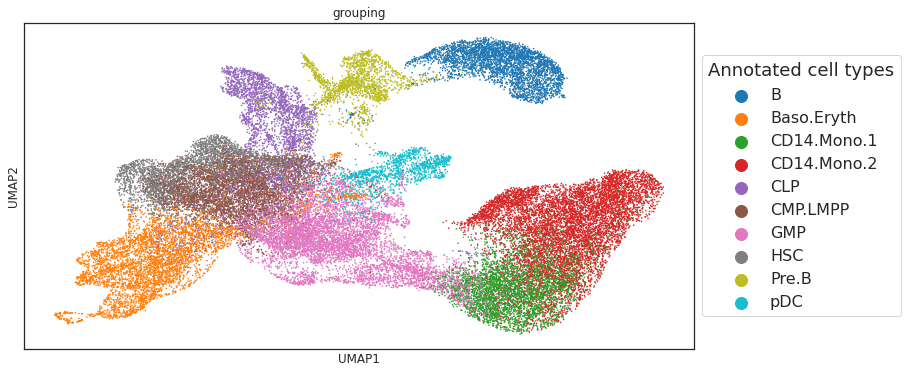

In [13]:
plt.rcParams["figure.figsize"] = [12,6]

fig = model.visualize_latent(
    color = ['grouping'], 
    method = "UMAP", size=10, return_fig=True)
plt.legend(title='Annotated cell types', fontsize=16, title_fontsize=18, markerscale=2,
          loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('Figure6a2.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Figure 6a-3

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


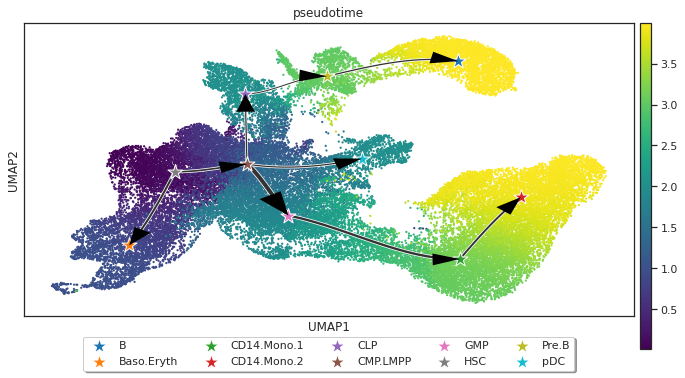

In [14]:
plt.rcParams["figure.figsize"] = [12,6]
sns.set(font_scale=2)
sns.set_theme(style='white')
model.infer_trajectory(5, size=20, cmap='viridis')
adata.obs['pseudotime'] = model.pseudotime
plt.savefig('Figure6a3.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Figure S6a-3

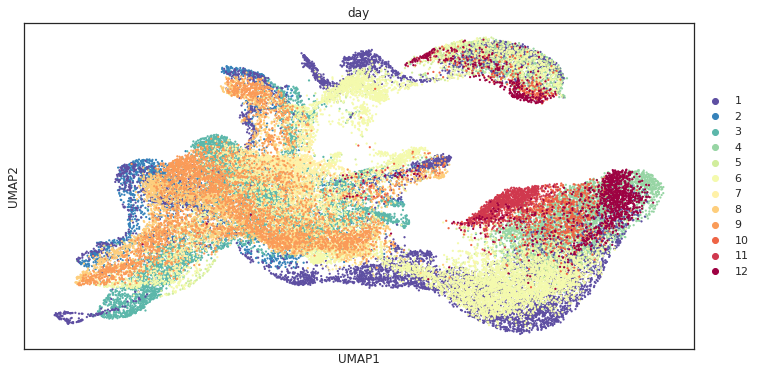

In [15]:
plt.rcParams["figure.figsize"] = [12,6]
sns.set(font_scale=2)
sns.set_theme(style='white')
fig = model.visualize_latent(color = 'day', s=20, palette='Spectral_r',
                             method = "UMAP", return_fig=True)
plt.savefig('FigureS5a3.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Figure 6b & S6b

In [16]:
sns.set(font_scale=1.5)
sns.set_theme(style='white')

df = pd.DataFrame(
    {'umap_1':model._adata.obsm['X_umap'][:,0],
    'umap_2':model._adata.obsm['X_umap'][:,1],
     'celltype':model._adata.obs['grouping'].values,
     'source':model._adata.obs['id_dataset'].values
    }
)
df['pseudotime'] = model.pseudotime

/tmp/ipykernel_2320121/915697489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['celltype'] = _df['celltype'].astype(str)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Ti

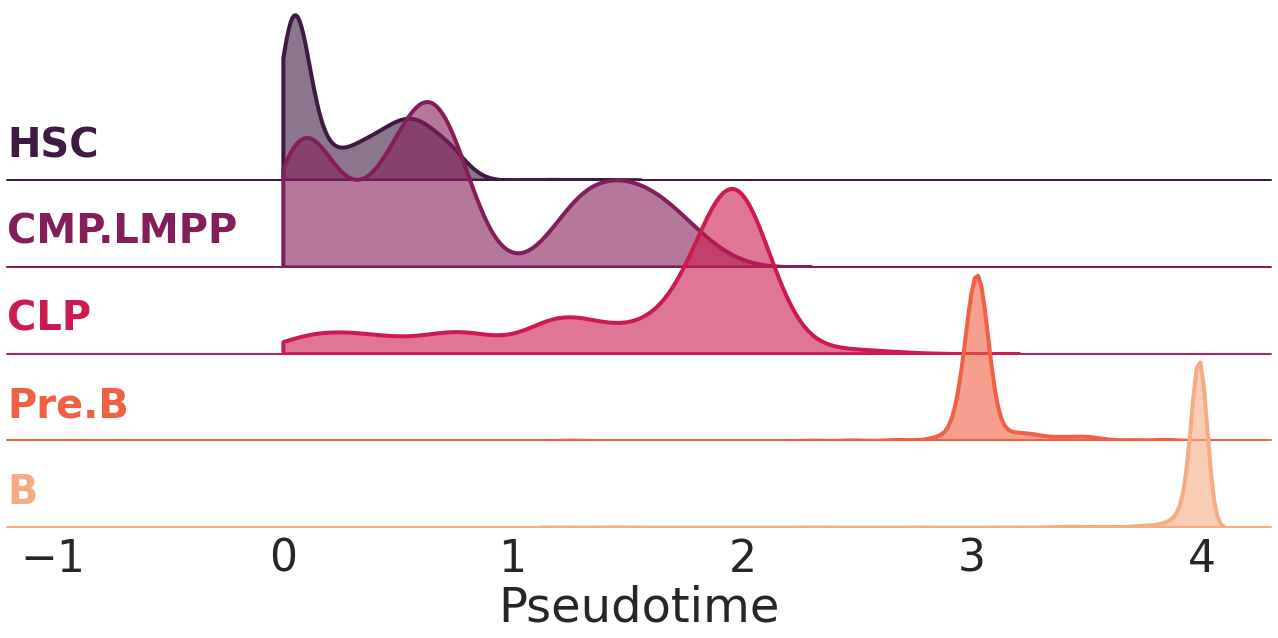

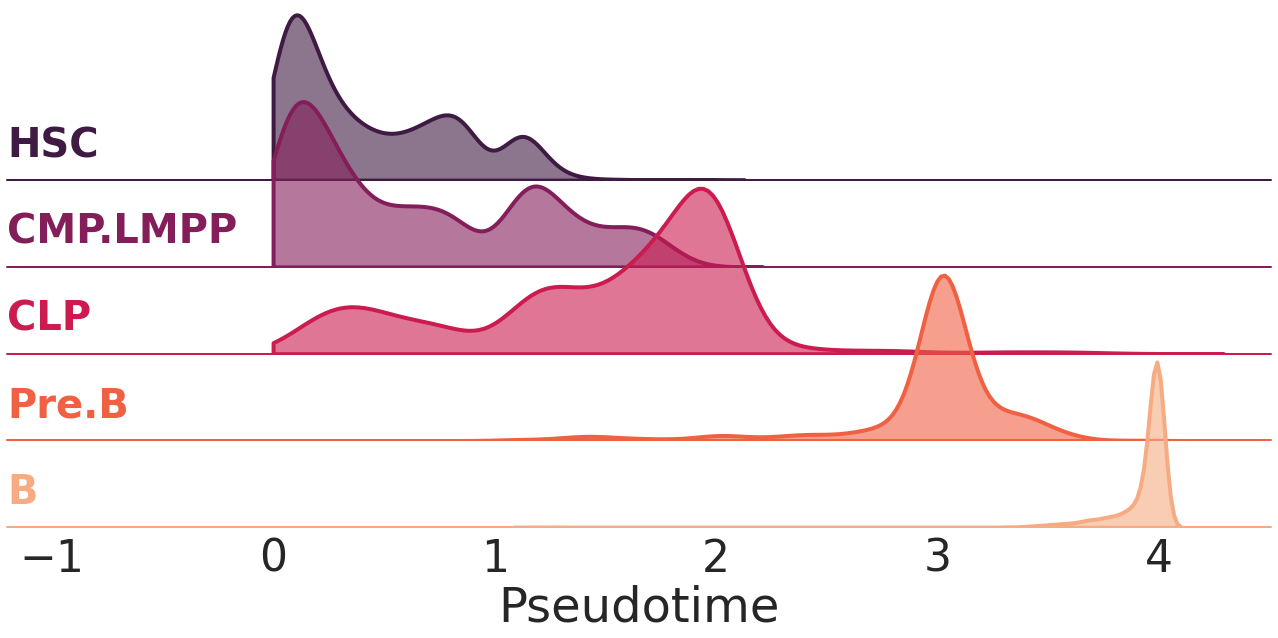

In [17]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=4)


for source in ['scRNA', 'scATAC']:
    lineage = ['HSC','CMP.LMPP', 'CLP','Pre.B', 'B']
    # Initialize the FacetGrid object
    pal = sns.color_palette("rocket", len(lineage))#sns.cubehelix_palette(10, rot=-.25, light=.7)


    _df = df[(df['celltype'].isin(lineage)) & (df['source']==source)]
    _df['celltype'] = _df['celltype'].astype(str)
    g = sns.FacetGrid(_df, row="celltype", row_order=lineage, 
                      hue="celltype", hue_order=lineage,  
                      sharey=False, aspect=10, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "pseudotime",
    #       kde=True, stat='density',
    #       kde_kws={'bw_adjust':.5, 'cut':3, 'shade':True}, 
        bw_adjust=1., cut=3, clip=[0,5],
          common_norm=False,
          fill=True, alpha=0.6, linewidth=4.
         )
    # g.map(sns.kdeplot, "pseudotime", 
    #       cut=3, clip=[0,5], color="w", lw=2, bw_adjust=1.)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0., .2, label, fontweight="bold", color=color, size=40,
                ha="left", va="center", transform=ax.transAxes)

    g.set(xlim=(-1.2, None))


    g.map(label, "pseudotime")

    # # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel='Pseudotime')
    g.despine(bottom=True, left=True)

    g.figure.savefig("pseudotime_B_lineage_{}.png".format(source))

/tmp/ipykernel_2320121/1994657129.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['celltype'] = _df['celltype'].astype(str)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: T

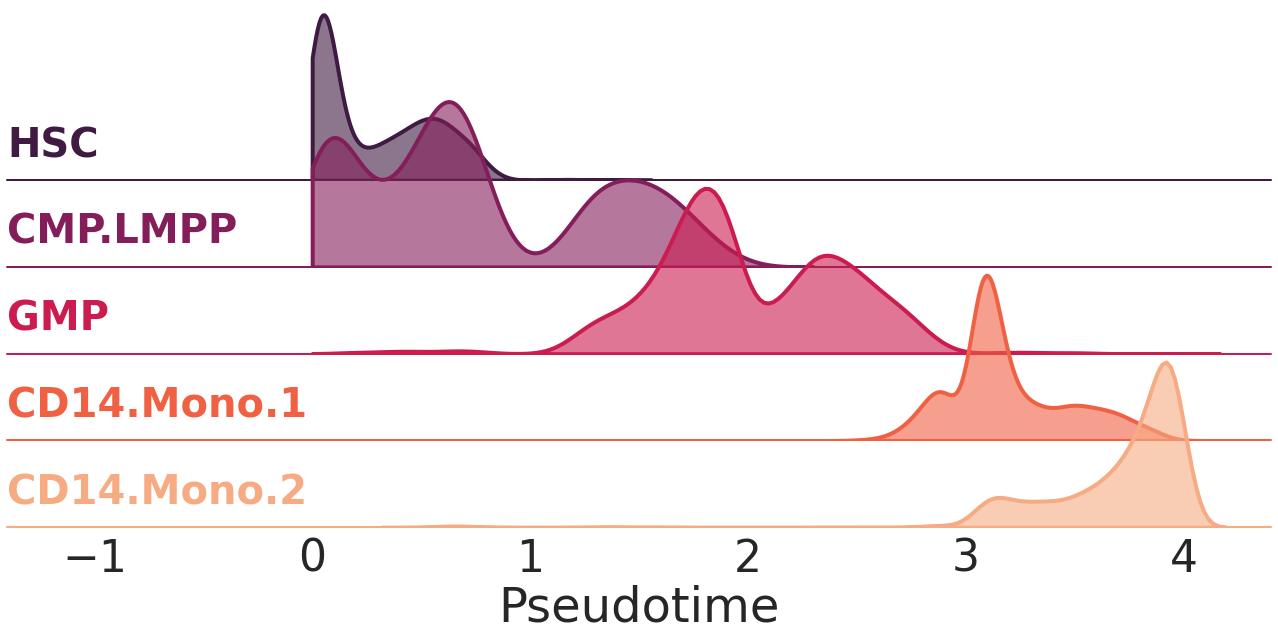

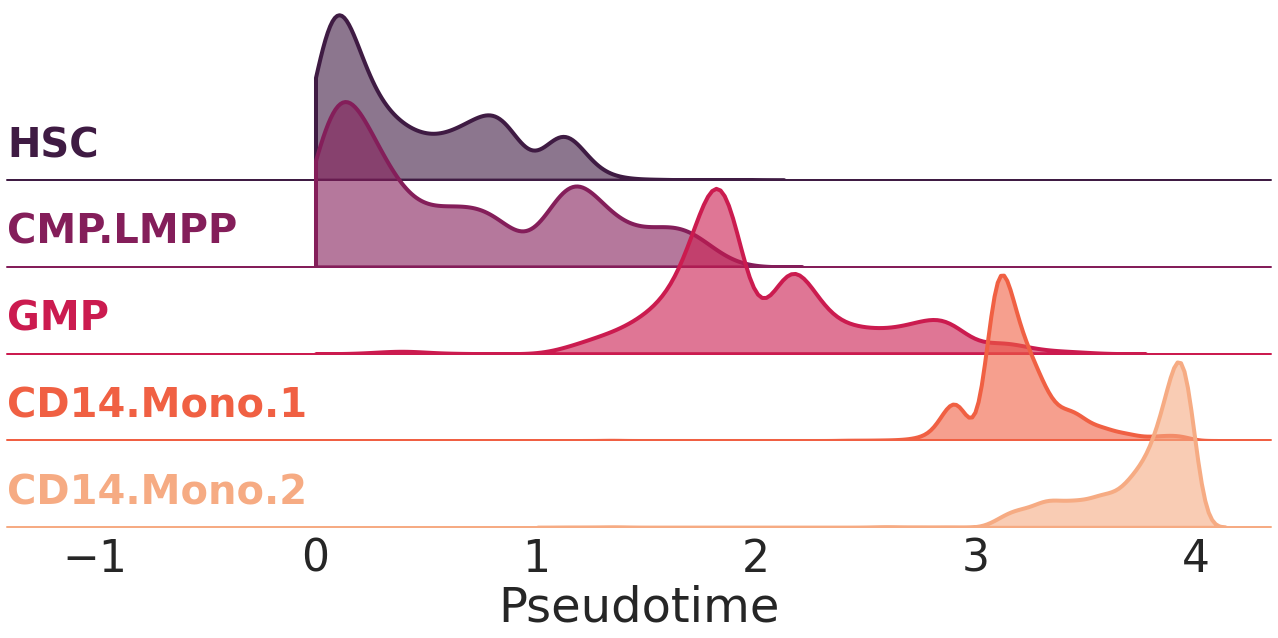

In [18]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=4)


for source in ['scRNA', 'scATAC']:
    lineage = ['HSC','CMP.LMPP', 'GMP','CD14.Mono.1', 'CD14.Mono.2']
    # Initialize the FacetGrid object
    pal = sns.color_palette("rocket", len(lineage))#sns.cubehelix_palette(10, rot=-.25, light=.7)


    _df = df[(df['celltype'].isin(lineage)) & (df['source']==source)]
    _df['celltype'] = _df['celltype'].astype(str)
    g = sns.FacetGrid(_df, row="celltype", row_order=lineage, 
                      hue="celltype", hue_order=lineage,  
                      sharey=False, aspect=10, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "pseudotime",
    #       kde=True, stat='density',
    #       kde_kws={'bw_adjust':.5, 'cut':3, 'shade':True}, 
        bw_adjust=1., cut=3, clip=[0,5],
          common_norm=False,
          fill=True, alpha=0.6, linewidth=4.
         )
    # g.map(sns.kdeplot, "pseudotime", 
    #       cut=3, clip=[0,5], color="w", lw=2, bw_adjust=1.)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, size=40,
                ha="left", va="center", transform=ax.transAxes)

    g.set(xlim=(-1.4, None))


    g.map(label, "pseudotime")

    # # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel='Pseudotime')
    g.despine(bottom=True, left=True)

    g.figure.savefig("pseudotime_CD14_lineage_{}.png".format(source))

# Figure 6c

## DE test

In [19]:
from scipy import stats
from VITAE.utils import DE_test

from scipy import stats

alpha = 0.01
res_DE = pd.DataFrame()
for cell_type in np.unique(model.labels):
    i = np.where(model.labels_map==cell_type)[0][0]
    
    cell_subset = np.argmax(model.cell_position_posterior, axis=1)==i
    # Prepare X and Y for regression expression ~ rank(PDT) + covariates
    Y = model.adata.X[cell_subset,:]
    X = model.cell_position_posterior[cell_subset,i:i+1]

    if model.covariates is None:
        X = np.c_[np.ones_like(X), X]
    else:
        X = np.c_[np.ones_like(X), X, model.covariates[cell_subset,:]]    

    res_df = DE_test(Y, X, 
                     model.adata.var_names, 
                     np.arange(1)+1, alpha)
    res_df.columns = ['beta', 'pvalue', 'pvalue_adjusted']
    res_df['cell_type'] = cell_type    

    res_DE = pd.concat([res_DE,res_df], axis=0)

In [20]:
res_DE = res_DE.sort_values(
    ['cell_type', 'beta'], ascending=False)
cell_types = ['HSC', 'Baso.Eryth', 'CMP.LMPP', 'CLP', 'pDC', 'Pre.B', 'B', 'GMP', 'CD14.Mono.1', 'CD14.Mono.2']
res_DE['ic'] = res_DE['cell_type'].map({j:i for i,j in enumerate(cell_types)})
res_DE = res_DE.sort_values('ic')
marker_genes = list(res_DE.index)

res_DE['logfc'] = np.nan
for i, cell_type in enumerate(cell_types):
    il = np.where(model.labels_map==cell_type)[0][0]
    cell_subset = np.argmax(model.cell_position_posterior, axis=1)==il
    marker_genes = list(res_DE[res_DE['cell_type']==cell_type].index)
    _adata = adata[:,marker_genes]
    expr = _adata.X * _adata.var['std'].values.reshape((1,-1)) + _adata.var['mean'].values.reshape((1,-1))
    res_DE.loc[res_DE['cell_type']==cell_type, 'logfc'] = np.log2((np.mean(expr[cell_subset], axis=0)+1e-6)/(np.mean(expr[~cell_subset], axis=0)+1e-6))

# res_DE.to_csv('res_DE.csv')

_res_DE = res_DE.sort_values(
    ['cell_type', 'logfc'], ascending=False).groupby('cell_type').head(10)

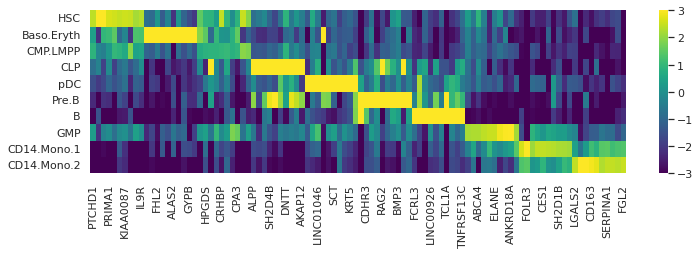

In [21]:
sns.set(font_scale=1.)
_res_DE = _res_DE.sort_values('ic')
marker_genes = list(_res_DE.index)
mat = np.zeros((len(cell_types),len(marker_genes)))
for i, cell_type in enumerate(cell_types):
    il = np.where(model.labels_map==cell_type)[0][0]
    cell_subset = np.argmax(model.cell_position_posterior, axis=1)==il
    _adata = adata[:,marker_genes]
    expr = _adata.X * _adata.var['std'].values.reshape((1,-1)) + _adata.var['mean'].values.reshape((1,-1))
    mat[i,:] = np.log2((np.mean(expr[cell_subset], axis=0)+1e-6)/(np.mean(expr[~cell_subset], axis=0)+1e-6))
res_fc = pd.DataFrame(mat, columns=marker_genes, index=cell_types)

fig, ax = plt.subplots(1,1,figsize=(12,3))
ax = sns.heatmap(res_fc, cmap=sns.color_palette("viridis", as_cmap=True), 
                 vmin=-3, vmax=3, ax=ax)
plt.savefig('Figure6d.png', dpi=300, bbox_inches='tight', pad_inches=0)

## CEBPB

In [28]:
celltyle_subsets = [
    ['GMP','CD14.Mono.1','CD14.Mono.2'],
    ['HSC', 'Baso.Eryth'],
    ['CLP','Pre.B','B']
]


gene_name = 'CEBPB'
target_gene_name = 'GIMAP4'
motif_names = np.array(adata_motif.var_names, dtype=str)
motif_names = motif_names[np.char.find(motif_names, gene_name)>=0]

motif_name = motif_names[0]
celltyle_subset = celltyle_subsets[0]

n_atac = adata_motif.X.shape[0]
n_rna = adata.X.shape[0] - adata_motif.X.shape[0]
pseudotime = adata.obs['pseudotime']
cell_subsets = adata.obs['grouping'].isin(celltyle_subset).values

df_res = pd.DataFrame()

cell_subset = cell_subsets[-n_atac:]
pseudotime_atac = pseudotime[-n_atac:][cell_subset]#stats.rankdata(pseudotime[-n_atac:][cell_subset])
motif = adata_motif.X[cell_subset,:][:,np.array(adata_motif.var_names)==motif_name]
atac = np.array(adata[n_rna:,][:,gene_name].X).T[0,cell_subset]

cell_subset = cell_subsets[:n_rna]
pseudotime_rna = pseudotime[:n_rna][cell_subset]#stats.rankdata(pseudotime[:n_rna][cell_subset])
rna = np.array(adata[:n_rna,][:,gene_name].X).T[0,cell_subset]
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
              atac[np.argsort(pseudotime_atac)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'GA'
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_rna)/np.max(pseudotime_rna), 
              rna[np.argsort(pseudotime_rna)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'RNA'
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
            np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
                  motif[np.argsort(pseudotime_atac)]
                 ],
            columns=['pseudotime', 'value']
        )
_df['type'] = 'motif'
df_res = pd.concat([df_res, _df])

cell_subset = cell_subsets[-n_atac:]
pseudotime_atac = pseudotime[-n_atac:][cell_subset]#stats.rankdata(pseudotime[-n_atac:][cell_subset])
atac = np.array(adata[n_rna:,][:,target_gene_name].X).T[0,cell_subset]

cell_subset = cell_subsets[:n_rna]
pseudotime_rna = pseudotime[:n_rna][cell_subset]#stats.rankdata(pseudotime[:n_rna][cell_subset])
rna = np.array(adata[:n_rna,][:,target_gene_name].X).T[0,cell_subset]
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
              atac[np.argsort(pseudotime_atac)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'target GA'
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_rna)/np.max(pseudotime_rna), 
              rna[np.argsort(pseudotime_rna)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'target RNA'
df_res = pd.concat([df_res, _df])

df_res['group'] = (df_res['pseudotime']*20).astype(int)
df_res = df_res.groupby(['type','group']).mean()
df_res = df_res.reset_index()
df_res['value'] = df_res.groupby(['type'])['value'].apply(lambda x : (x-x.min())/(x.max()-x.min())).reset_index(drop=True)
df_res = df_res.reset_index()

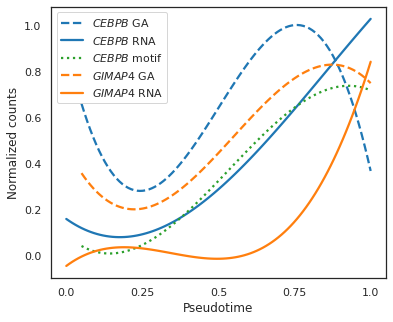

In [30]:
sns.set(font_scale=1.2)
sns.set_theme(style='white')

fig, ax = plt.subplots(1,1, figsize=(6,5))
c_dict = {
    'GA':sns.color_palette("tab10")[0], 
    'RNA':sns.color_palette("tab10")[0], 
    'motif':sns.color_palette("tab10")[2], 
    'target GA':sns.color_palette("tab10")[1], 
    'target RNA':sns.color_palette("tab10")[1]
}
ls_dict = {
    'GA':'--', 'RNA':'-', 'motif':':', 'target GA':'--', 'target RNA':'-'
}
for i in df_res['type'].unique():
    
    sns.regplot(
        data = df_res[df_res['type']==i],
        x = 'group', y = 'value', 
        order=3, 
        color=c_dict[i],
#         stat='density',
#         lowess=True,
        scatter=False, ci=None, line_kws={'linestyle':ls_dict[i]},
        ax=ax, label=i)
ax.legend()
ax.set_xlabel('Pseudotime')
xticks = np.arange(0, len(np.unique(df_res['group'])),5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks/np.max(xticks))
# ax.set_ylim([-0.1,1.1])
ax.set_ylabel('Normalized counts')

lines_labels = [ax.get_legend_handles_labels() for ax in [ax]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['${}$ GA'.format(gene_name), 
          '${}$ RNA'.format(gene_name),
          '${}$ motif'.format(motif_name.split('_')[0]),
          '${}$ GA'.format(target_gene_name), 
          '${}$ RNA'.format(target_gene_name),
]

ax.get_legend().remove()
legend = ax.legend(handles=handles, labels=labels,
                    loc=0, ncol=1, title=None)

plt.savefig('fig_motif_{}.png'.format(gene_name), dpi=300, bbox_inches='tight', pad_inches=0)

## GATA1

In [31]:
celltyle_subsets = [
    ['GMP','CD14.Mono.1','CD14.Mono.2'],
    ['HSC', 'Baso.Eryth'],
    ['CLP','Pre.B','B']
]


gene_name = 'GATA1'#'PAX5'# 'CEBPB'
target_gene_name = 'RHAG'# 'LDB3'# # 'GIMAP4'
motif_names = np.array(adata_motif.var_names, dtype=str)
motif_names = motif_names[np.char.find(motif_names, gene_name)>=0]

motif_name = motif_names[0]
celltyle_subset = celltyle_subsets[1]

n_atac = adata_motif.X.shape[0]
n_rna = adata.X.shape[0] - adata_motif.X.shape[0]
pseudotime = adata.obs['pseudotime']
cell_subsets = adata.obs['grouping'].isin(celltyle_subset).values

df_res = pd.DataFrame()

cell_subset = cell_subsets[-n_atac:]
pseudotime_atac = stats.rankdata(pseudotime[-n_atac:][cell_subset])
motif = adata_motif.X[cell_subset,:][:,np.array(adata_motif.var_names)==motif_name]
atac = np.array(adata[n_rna:,][:,gene_name].X).T[0,cell_subset]

cell_subset = cell_subsets[:n_rna]
pseudotime_rna = stats.rankdata(pseudotime[:n_rna][cell_subset])
rna = np.array(adata[:n_rna,][:,gene_name].X).T[0,cell_subset]
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
              atac[np.argsort(pseudotime_atac)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'GA'
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_rna)/np.max(pseudotime_rna), 
              rna[np.argsort(pseudotime_rna)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'RNA'
_df['value'] = (_df['value']-_df['value'].min())
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
            np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
                  motif[np.argsort(pseudotime_atac)]
                 ],
            columns=['pseudotime', 'value']
        )
_df['type'] = 'motif'
df_res = pd.concat([df_res, _df])

cell_subset = cell_subsets[-n_atac:]
pseudotime_atac = stats.rankdata(pseudotime[-n_atac:][cell_subset])
atac = np.array(adata[n_rna:,][:,target_gene_name].X).T[0,cell_subset]

cell_subset = cell_subsets[:n_rna]
pseudotime_rna = stats.rankdata(pseudotime[:n_rna][cell_subset])
rna = np.array(adata[:n_rna,][:,target_gene_name].X).T[0,cell_subset]
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_atac)/np.max(pseudotime_atac), 
              atac[np.argsort(pseudotime_atac)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'target GA'
df_res = pd.concat([df_res, _df])
_df = pd.DataFrame(
        np.c_[np.sort(pseudotime_rna)/np.max(pseudotime_rna), 
              rna[np.argsort(pseudotime_rna)]
             ],
        columns=['pseudotime', 'value']
    )
_df['type'] = 'target RNA'
df_res = pd.concat([df_res, _df])

df_res['group'] = (df_res['pseudotime']*15).astype(int)
df_res = df_res.groupby(['type','group']).mean()
df_res = df_res.reset_index()
df_res['value'] = df_res.groupby(['type'])['value'].apply(lambda x : (x-x.min())/(x.max()-x.min())).reset_index(drop=True)
df_res = df_res.reset_index()

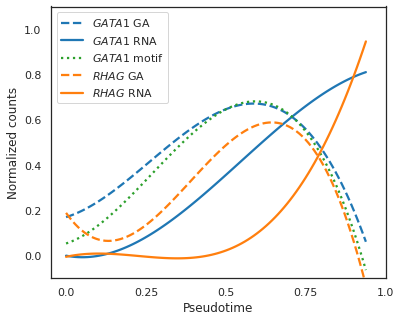

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
c_dict = {
    'GA':sns.color_palette("tab10")[0], 
    'RNA':sns.color_palette("tab10")[0], 
    'motif':sns.color_palette("tab10")[2], 
    'target GA':sns.color_palette("tab10")[1], 
    'target RNA':sns.color_palette("tab10")[1]
}
ls_dict = {
    'GA':'--', 'RNA':'-', 'motif':':', 'target GA':'--', 'target RNA':'-'
}
for i in df_res['type'].unique():
    
    sns.regplot(
        data = df_res[df_res['type']==i],
        x = 'group', y = 'value', 
        order=3, 
        color=c_dict[i],
#         stat='density',
#         lowess=True,
        scatter=False, ci=None, line_kws={'linestyle':ls_dict[i]},
        ax=ax, label=i)
ax.legend()
ax.set_xlabel('Pseudotime')
xticks = np.linspace(0, len(np.unique(df_res['group'])), 5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks/np.max(xticks))
ax.set_ylim([-0.1,1.1])
ax.set_ylabel('Normalized counts')

lines_labels = [ax.get_legend_handles_labels() for ax in [ax]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['${}$ GA'.format(gene_name), 
          '${}$ RNA'.format(gene_name),
          '${}$ motif'.format(motif_name.split('_')[0]),
          '${}$ GA'.format(target_gene_name), 
          '${}$ RNA'.format(target_gene_name),
]

ax.get_legend().remove()
legend = ax.legend(handles=handles, labels=labels,
                    loc=0, ncol=1, title=None)

plt.savefig('fig_motif_{}.png'.format(gene_name), dpi=300, bbox_inches='tight', pad_inches=0)